In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install hmmlearn


In [3]:
import os
import sys
import time
import numpy as np
import librosa 
import librosa.display
from collections import Counter

from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture as GMM
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
import matplotlib.style
import matplotlib as mpl
mpl.style.use('ggplot')
import tensorflow as tf
from itertools import chain
import keras.backend as K

from keras.datasets import mnist

from keras.models import Model, Sequential, load_model
from keras.layers import Input, Flatten, add, Reshape
from keras.layers import Conv1D, Conv2D, Dense, Activation, LeakyReLU
from keras.layers import Dropout, BatchNormalization, MaxPooling2D, MaxPooling1D, AveragePooling2D, LSTM
from keras.utils import np_utils, to_categorical
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.constraints import nonneg




Using TensorFlow backend.


# Load 10 genre

In [12]:
train_10 = np.load('/content/gdrive/My Drive/Grad Courses/EE511/Project/Music Data/msd-10-genre-train.npz')
val_10 = np.load('/content/gdrive/My Drive/Grad Courses/EE511/Project/Music Data/msd-10-genre-valid.npz')
num_classes = train_10['label_map'].shape[0]


X_train = train_10['inputs']
Y_train = train_10['targets']
X_test = val_10['inputs']
Y_test = val_10['targets']


X_train_mean = train_10['mean']
X_train_std = train_10['std']
X_train_std.shape



(120, 25)

In [5]:
print(train_10['label_map'])
print(X_train)


[b'rap' b'rock' b'rnb' b'electronic' b'metal' b'blues' b'pop' b'jazz'
 b'country' b'reggae']
[[[-0.08655 -1.191   -0.5464  ...  1.846   -0.615   -0.2074 ]
  [-0.336   -2.11    -1.594   ...  0.835    1.001   -0.5483 ]
  [ 0.0683  -1.456   -0.697   ...  1.591   -0.09595 -0.825  ]
  ...
  [ 0.972   -0.1576  -0.4114  ...  1.034    0.822    0.928  ]
  [ 1.332    0.03525 -0.7476  ...  1.884    0.676    1.265  ]
  [ 0.951   -0.1024  -1.071   ...  0.148   -0.2754   0.7993 ]]

 [[ 1.073    0.783   -0.185   ... -0.812   -0.592    1.165  ]
  [ 1.008    0.04364  0.9116  ... -1.013   -1.004    0.738  ]
  [ 1.1875   0.73     0.3843  ... -0.566    2.232    1.019  ]
  ...
  [-0.3186  -0.692   -0.956   ... -0.918    0.02951 -1.192  ]
  [-0.3289  -1.038   -0.9604  ... -0.6016   0.7964  -1.309  ]
  [-0.1017  -0.926   -0.1724  ... -0.6724   0.5684  -0.8887 ]]

 [[ 1.046    1.335   -0.2637  ...  1.624    0.1775   1.142  ]
  [ 1.057    1.021    0.02335 ...  0.417   -0.01323  1.123  ]
  [ 1.141    1.358   -0

In [6]:
class_name = train_10['label_map']
label_name =np.array([x.decode() for x in class_name])
print(label_name)
z = label_name[0]
z

['rap' 'rock' 'rnb' 'electronic' 'metal' 'blues' 'pop' 'jazz' 'country'
 'reggae']


'rap'

# Load 25 genre

In [20]:
train_25 = np.load('/content/gdrive/My Drive/Grad Courses/EE511/Project/Music Data/msd-25-genre-train.npz')
val_25 = np.load('/content/gdrive/My Drive/Grad Courses/EE511/Project/Music Data/msd-25-genre-valid.npz')
test_25 = np.load('/content/gdrive/My Drive/Grad Courses/EE511/Project/Music Data/msd-25-genre-test.npz')

num_classes_25 = train_25['label_map'].shape[0]


X_train_25 = train_25['inputs']
Y_train_25 = train_25['targets']
X_val_25 = val_25['inputs']
Y_val_25 = val_25['targets']
X_test_25= test_25['inputs']
Y_test_25= test_25['targets']


print(train_25['label_map'])
print(X_train_25.shape)
print(X_val_25.shape)
print(X_test_25.shape)





[b'big band' b'blues contemporary' b'country traditional' b'dance'
 b'electronica' b'experimental' b'folk international' b'gospel'
 b'grunge emo' b'hip hop rap' b'jazz classic' b'metal alternative'
 b'metal death' b'metal heavy' b'pop contemporary' b'pop indie'
 b'pop latin' b'punk' b'reggae' b'rnb soul' b'rock alternative'
 b'rock college' b'rock contemporary' b'rock hard' b'rock neo psychedelia']
(40000, 120, 25)
(10000, 120, 25)
(10000, 120, 25)


In [22]:
class_name = train_25['label_map']
label_name =np.array([x.decode() for x in class_name])
print(label_name)


['big band' 'blues contemporary' 'country traditional' 'dance'
 'electronica' 'experimental' 'folk international' 'gospel' 'grunge emo'
 'hip hop rap' 'jazz classic' 'metal alternative' 'metal death'
 'metal heavy' 'pop contemporary' 'pop indie' 'pop latin' 'punk' 'reggae'
 'rnb soul' 'rock alternative' 'rock college' 'rock contemporary'
 'rock hard' 'rock neo psychedelia']


# Random Classification: Randomly pick a class where each class is equally likely

In [0]:
y_pred = np.random.randint(0,10, size = Y_test.shape[0])


In [0]:
acc_rand = accuracy_score(Y_test, y_pred)*100
print('Accuracy of random classification: %0.2f%%' % acc_rand)


Accuracy of random classification: 10.32%


# Train-val split

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.10)


# Gaussian Mixture Model: using all the features

In [0]:
x_train = np.zeros((X_train.shape[0], X_train.shape[2]))
x_val = np.zeros((X_val.shape[0], X_val.shape[2]))


# for i in range(0, X_train.shape[0]):
#   x_train[i,:] = np.mean((np.multiply(X_train[i,:,:],X_train_std) + X_train_mean),axis=0)

# for i in range(0, X_val.shape[0]):
#   x_val[i,:] = np.mean((np.multiply(X_val[i,:,:],X_train_std) + X_train_mean),axis=0)

for i in range(0, X_train.shape[0]):
  x_train[i,:] = np.mean(X_train[i,:,:],axis=0)

for i in range(0, X_val.shape[0]):
  x_val[i,:] = np.mean(X_val[i,:,:],axis=0)
  
print(x_train[0])
print(x_val.shape)


[ 0.33618164  0.96240234 -0.95458984 -0.56542969  0.93017578  0.06854248
 -0.54003906  0.30029297  0.10516357  0.11248779 -0.31201172  0.64013672
  0.2722168   0.16430664 -0.05636597  0.140625    0.43505859  0.45336914
  0.91748047  0.77783203  0.80908203  0.76855469  0.59179688  0.40576172
  0.2388916 ]
(4000, 25)


In [0]:
mixtures = [GMM(n_components = 5, covariance_type = 'full') for k in range(num_classes)]
for k, mix in enumerate(mixtures):
  if any(y_train==k):
    mix.fit(x_train[y_train==k])
    
ll = np.zeros((x_val.shape[0], num_classes))

for i in range(0, x_val.shape[0]):
  for k, mix in enumerate(mixtures):

    ll[i,k] = mix.score(x_val[i,:].reshape(1,-1))

In [0]:
ypred = np.argmax(ll, axis=1)
acc_gmm = accuracy_score(y_val, ypred)*100
print('Accuracy of random classification: %0.2f%%' % acc_gmm)

Accuracy of random classification: 51.60%


# Gaussian Mixture Model: using only timbre data

In [0]:
x_train = np.zeros((X_train.shape[0], 12))
x_val = np.zeros((X_val.shape[0], 12))

for i in range(0, X_train.shape[0]):
  x_train[i,:] = np.mean(X_train[i,:,0:12],axis=0)

for i in range(0, X_val.shape[0]):
  x_val[i,:] = np.mean(X_val[i,:,0:12],axis=0)
  
print(x_train[0])
print(x_val.shape)



[ 0.33618164  0.96240234 -0.95458984 -0.56542969  0.93017578  0.06854248
 -0.54003906  0.30029297  0.10516357  0.11248779 -0.31201172  0.64013672]
(4000, 12)


In [0]:
mixtures = [GMM(n_components = 5, covariance_type = 'full') for k in range(num_classes)]
for k, mix in enumerate(mixtures):
  if any(y_train==k):
    mix.fit(x_train[y_train==k])
    
ll = np.zeros((x_val.shape[0], num_classes))

for i in range(0, x_val.shape[0]):
  for k, mix in enumerate(mixtures):

    ll[i,k] = mix.score(x_val[i,:].reshape(1,-1))

In [0]:
ypred = np.argmax(ll, axis=1)
acc_gmm_tim = accuracy_score(y_val, ypred)*100
print('Accuracy of random classification: %0.2f%%' % acc_gmm_tim)

Accuracy of random classification: 47.35%


# Hidden Markov Model for timbre data: DOESN'T WORK YET


In [0]:
X_train_timbre = np.copy(X_train[:,:, 0:12])
X_val_timbre = np.copy(X_val[:,:, 0:12])
x_train = np.zeros((X_train_timbre.shape[0], X_train_timbre.shape[2]+1))
x_val = np.zeros((X_val_timbre.shape[0], X_val_timbre.shape[2]+1))
x_train.shape


(36000, 13)

In [0]:
for i in range(0, X_train_timbre.shape[0]):
  x_train[i, 0:12] = np.argmax(X_train_timbre[i,:,:], axis=0)
  
for i in range(0, X_val_timbre.shape[0]):
  x_val[i, 0:12] = np.argmax(X_val_timbre[i,:,:], axis=0)
  
  
print(x_train.shape)

(36000, 13)


In [0]:
mixtures = [hmm.GaussianHMM(n_components = 6, init_params='s') for k in range(num_classes)]
for k, mix in enumerate(mixtures):
  if any(y_train==k):
    mix.startprob_ = np.array([1/6, 1/6,1/6,1/6,1/6,1/6])
    mix.fit(x_train[y_train==k])
    
ll = np.zeros((x_val.shape[0], num_classes))

for i in range(0, x_val.shape[0]):
  for k, mix in enumerate(mixtures):

    ll[i,k] = mix.score(x_val[i,:].reshape(1,-1))

In [0]:
ypred = np.argmax(ll, axis=1)
acc_hmm= accuracy_score(y_val, ypred)*100
print('Accuracy of random classification: %0.2f%%' % acc_hmm)


Accuracy of random classification: 8.95%


# Simple 2 layer NN

In [0]:
X_train_rs = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
print(X_train_rs.shape)
X_val_rs = X_val.reshape((X_val.shape[0], X_val.shape[1]*X_val.shape[2]))
print(X_val_rs.shape)

(36000, 3000)
(4000, 3000)


In [0]:
model_name = 'simple_nn.h5'
input_shape = X_train_rs.shape[1:]

x_in = Input(shape=input_shape)

x = Dense(1000)(x_in)
x = Activation('relu')(x)
x = BatchNormalization()(x)

x = Dense(1000)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)

x_out = Dense(num_classes)(x)
# x = Dropout(0.5)(x)
x_out = Activation('softmax')(x)

model = Model(inputs=x_in, outputs=x_out)

model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics= ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3000)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1000)              3001000   
_________________________________________________________________
activation_13 (Activation)   (None, 1000)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000)              4000      
_________________________________________________________________
dense_14 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
activation_14 (Activation)   (None, 1000)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000)              4000      
__________

In [0]:
history = model.fit(X_train_rs, y_train, epochs = 20, batch_size=128, validation_data = (X_val_rs, y_val), verbose=1)
model.save('/content/gdrive/My Drive/Project/Music Data/'+model_name)

Train on 36000 samples, validate on 4000 samples
Epoch 1/20
36000/36000 [==============================] - 5s 144us/step - loss: 5.1891 - acc: 0.3907 - val_loss: 4.6403 - val_acc: 0.4675
Epoch 2/20
36000/36000 [==============================] - 4s 121us/step - loss: 3.8795 - acc: 0.5506 - val_loss: 3.7650 - val_acc: 0.4763
Epoch 3/20
36000/36000 [==============================] - 4s 121us/step - loss: 2.7040 - acc: 0.6716 - val_loss: 3.2884 - val_acc: 0.4700
Epoch 4/20
36000/36000 [==============================] - 4s 121us/step - loss: 1.7476 - acc: 0.7961 - val_loss: 3.1519 - val_acc: 0.4645
Epoch 5/20
36000/36000 [==============================] - 4s 121us/step - loss: 1.1389 - acc: 0.8731 - val_loss: 3.0187 - val_acc: 0.4505
Epoch 6/20
36000/36000 [==============================] - 4s 121us/step - loss: 0.8081 - acc: 0.9037 - val_loss: 2.9979 - val_acc: 0.4535
Epoch 7/20
36000/36000 [==============================] - 4s 120us/step - loss: 0.6212 - acc: 0.9197 - val_loss: 2.9898 - v

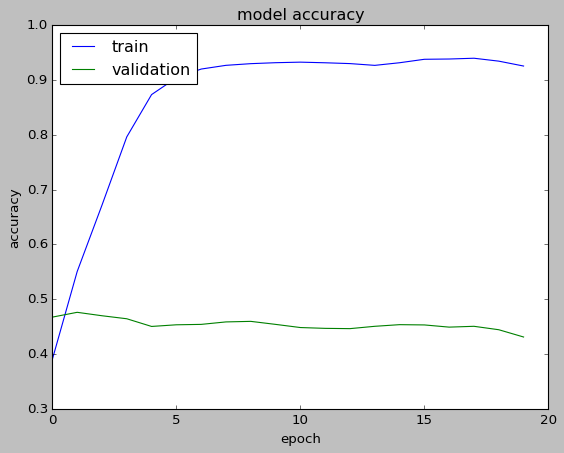

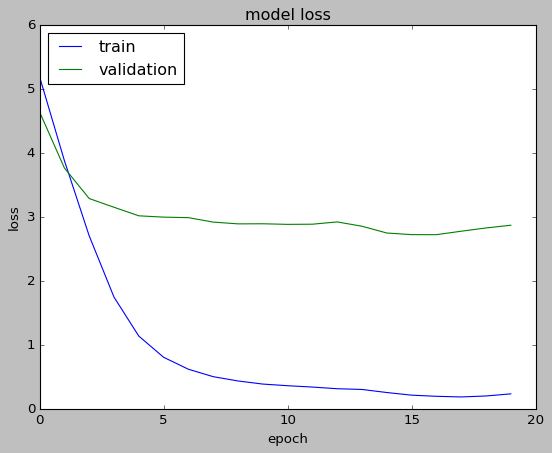

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# CNN-all features-10genre

In [0]:

X_train_cnn = np.expand_dims(X_train, axis=3)
X_val_cnn = np.expand_dims(X_val, axis=3)

In [75]:

def build_model(X,Y,nb_classes):
    nb_filters = 64  
    pool_size = (4, 4)  
    kernel_size = (2, 2) 
    nb_layers = 3
    input_shape = (X_train.shape[1], X_train.shape[2],1)

    model = Sequential()
    model.add(Conv2D(nb_filters, kernel_size=kernel_size,activation='relu',input_shape=input_shape,padding='valid'))
    

    for layer in range(nb_layers-1):
        model.add(Conv2D(nb_filters, kernel_size=kernel_size, activation='relu'))
        model.add(MaxPooling2D(pool_size=pool_size))
        model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes,activation='softmax'))
    return model

model = build_model(X_train_cnn.astype(float),y_train.astype(float),num_classes)
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 119, 24, 64)       320       
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 118, 23, 64)       16448     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 29, 5, 64)         0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 29, 5, 64)         0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 28, 4, 64)         16448     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 7, 1, 64)          0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 7, 1, 64)          0         
__________

In [77]:
checkpointer = ModelCheckpoint(filepath='/content/gdrive/My Drive/Grad Courses/EE511/Project/Music Data/cnn_all_2d.hdf5', verbose=1, save_best_only=True)

history_cnn = model.fit(X_train_cnn.astype(float),y_train.astype(float), batch_size=100, epochs=20, verbose=1, validation_data=(X_val_cnn.astype(float), y_val.astype(float)), callbacks=[checkpointer])


Train on 36000 samples, validate on 4000 samples
Epoch 1/20
36000/36000 [==============================] - 21s 586us/step - loss: 1.7069 - acc: 0.3836 - val_loss: 1.5769 - val_acc: 0.4202

Epoch 00001: val_loss improved from inf to 1.57690, saving model to /content/gdrive/My Drive/Grad Courses/EE511/Project/Music Data/cnn_all_2d.hdf5
Epoch 2/20
36000/36000 [==============================] - 19s 534us/step - loss: 1.6261 - acc: 0.4204 - val_loss: 1.5613 - val_acc: 0.4302

Epoch 00002: val_loss improved from 1.57690 to 1.56134, saving model to /content/gdrive/My Drive/Grad Courses/EE511/Project/Music Data/cnn_all_2d.hdf5
Epoch 3/20
36000/36000 [==============================] - 19s 536us/step - loss: 1.5645 - acc: 0.4422 - val_loss: 1.5258 - val_acc: 0.4542

Epoch 00003: val_loss improved from 1.56134 to 1.52581, saving model to /content/gdrive/My Drive/Grad Courses/EE511/Project/Music Data/cnn_all_2d.hdf5
Epoch 4/20
36000/36000 [==============================] - 19s 532us/step - loss: 1

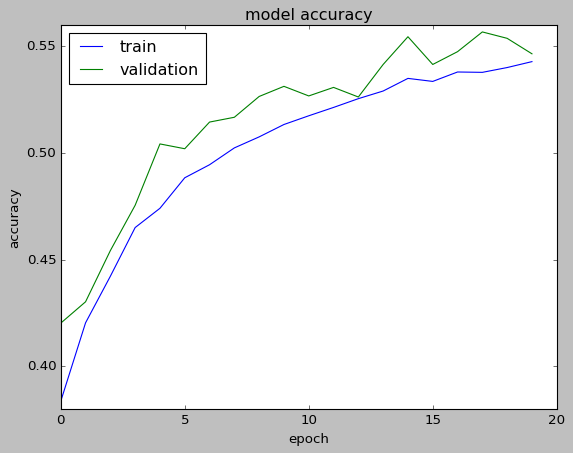

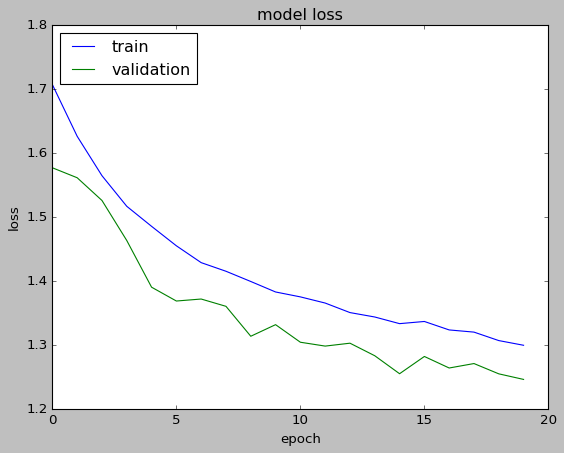

In [78]:
# "Accuracy"
plt.plot(history_cnn.history['acc'])
plt.plot(history_cnn.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


# CNN-all features-25genre

In [23]:
X_train_25cnn = np.expand_dims(X_train_25, axis=3)
X_val_25cnn = np.expand_dims(X_val_25, axis=3)

def build_model(X,Y,nb_classes):
    nb_filters = 64  
    pool_size = (4, 4)  
    kernel_size = (2, 2) 
    nb_layers = 3
    input_shape = (X_train.shape[1], X_train.shape[2],1)

    model = Sequential()
    model.add(Conv2D(nb_filters, kernel_size=kernel_size,activation='relu',input_shape=input_shape,padding='valid'))
    

    for layer in range(nb_layers-1):
        model.add(Conv2D(nb_filters, kernel_size=kernel_size, activation='relu'))
        model.add(MaxPooling2D(pool_size=pool_size))
        model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes,activation='softmax'))
    return model

model = build_model(X_train_25cnn.astype(float),Y_train_25.astype(float),num_classes_25)
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 119, 24, 64)       320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 118, 23, 64)       16448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 5, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 5, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 4, 64)         16448     
_________________________________________________________________
max_pooling2d_2 (MaxP

In [25]:
checkpointer = ModelCheckpoint(filepath='/content/gdrive/My Drive/Grad Courses/EE511/Project/Music Data/cnn_all_25.hdf5', verbose=1, save_best_only=True)

history_cnn = model.fit(X_train_25cnn.astype(float),Y_train_25.astype(float), batch_size=100, epochs=20, verbose=1, validation_data=(X_val_25cnn.astype(float), Y_val_25.astype(float)), callbacks=[checkpointer])


Instructions for updating:
Use tf.cast instead.
Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 25s 633us/step - loss: 3.0833 - acc: 0.0762 - val_loss: 2.8572 - val_acc: 0.1319

Epoch 00001: val_loss improved from inf to 2.85720, saving model to /content/gdrive/My Drive/Grad Courses/EE511/Project/Music Data/cnn_all_25.hdf5
Epoch 2/20
40000/40000 [==============================] - 20s 506us/step - loss: 2.8391 - acc: 0.1336 - val_loss: 2.7508 - val_acc: 0.1666

Epoch 00002: val_loss improved from 2.85720 to 2.75079, saving model to /content/gdrive/My Drive/Grad Courses/EE511/Project/Music Data/cnn_all_25.hdf5
Epoch 3/20
40000/40000 [==============================] - 20s 505us/step - loss: 2.7598 - acc: 0.1547 - val_loss: 2.6956 - val_acc: 0.1771

Epoch 00003: val_loss improved from 2.75079 to 2.69564, saving model to /content/gdrive/My Drive/Grad Courses/EE511/Project/Music Data/cnn_all_25.hdf5
Epoch 4/20
40000/40000 [=========

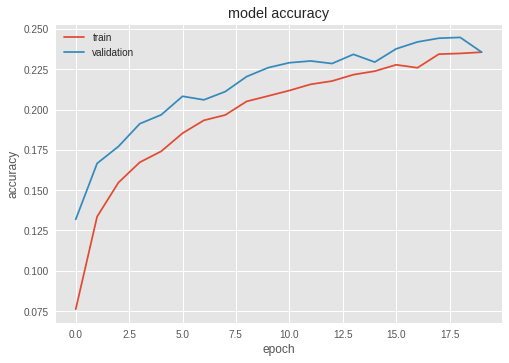

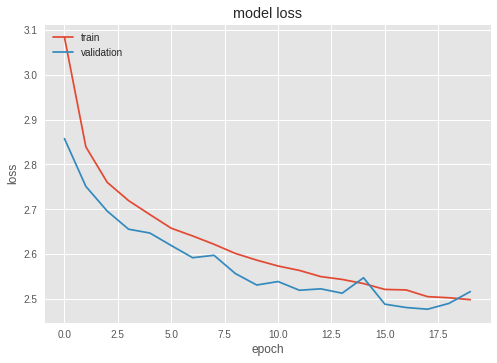

In [26]:
# "Accuracy"
plt.plot(history_cnn.history['acc'])
plt.plot(history_cnn.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


# CRNN_all features_10genre

In [78]:
# CRNN for all #


nb_filters = 128  
pool_size = (4, 4)  
kernel_size = (2, 2) 
nb_layers = 3
input_shape = (X_train.shape[1], X_train.shape[2],1)
    
print(input_shape)    
x_in = Input(shape =input_shape )
x = Conv2D(nb_filters, kernel_size=kernel_size,activation='relu',input_shape=input_shape,padding='valid')(x_in)
    
x = Conv2D(nb_filters, kernel_size=kernel_size, activation='relu')(x)
x = MaxPooling2D(pool_size=pool_size)(x)
x = Dropout(0.25)(x)
    
x = Conv2D(nb_filters, kernel_size=kernel_size, activation='relu')(x)
x = MaxPooling2D(pool_size=pool_size)(x)
x = Dropout(0.25)(x)
    
x_shape = x.get_shape()
 
x = Reshape(target_shape = (int(x_shape[1]),int(x_shape[2] * x_shape[3])))(x)
print(x.get_shape())

x = Dense(32, activation='relu')(x)
    
rnn_1= LSTM(128, kernel_initializer="he_normal", return_sequences=True)(x)
rnn_1b = LSTM(128, kernel_initializer="he_normal", go_backwards=True, return_sequences=True)(x)
    
rnn1_merged = add([rnn_1, rnn_1b])

rnn_2 = LSTM(128, kernel_initializer="he_normal", return_sequences=True)(rnn1_merged)
rnn_2b = LSTM(128, kernel_initializer="he_normal", go_backwards=True, return_sequences=True)(rnn1_merged)
    
rnn2_merged = add([rnn_2, rnn_2b])

rnn2_merged = Dropout(0.25)(rnn2_merged)

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(num_classes,activation='softmax')(x)

    

model_crnn = Model(inputs = x_in, outputs = x)
model_crnn.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_crnn.summary()


(120, 25, 1)
(?, 7, 128)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 120, 25, 1)        0         
_________________________________________________________________
conv2d_156 (Conv2D)          (None, 119, 24, 128)      640       
_________________________________________________________________
conv2d_157 (Conv2D)          (None, 118, 23, 128)      65664     
_________________________________________________________________
max_pooling2d_103 (MaxPoolin (None, 29, 5, 128)        0         
_________________________________________________________________
dropout_111 (Dropout)        (None, 29, 5, 128)        0         
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 28, 4, 128)        65664     
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 7, 1, 128)     

In [79]:
checkpointer_crnn = ModelCheckpoint(filepath='/content/gdrive/My Drive/Grad Courses/EE511/Project/Music Data/crnn_all_2d.hdf5', verbose=1, save_best_only=True)

history_crnn = model_crnn.fit(X_train_cnn.astype(float),y_train.astype(float), batch_size=100, epochs=20, verbose=1, validation_data=(X_val_cnn.astype(float), y_val.astype(float)), callbacks=[checkpointer])


Instructions for updating:
Use tf.cast instead.
Train on 36000 samples, validate on 4000 samples
Epoch 1/20
36000/36000 [==============================] - 54s 2ms/step - loss: 1.9643 - acc: 0.2639 - val_loss: 1.6832 - val_acc: 0.3827

Epoch 00001: val_loss improved from inf to 1.68320, saving model to /content/gdrive/My Drive/Grad Courses/EE511/Project/Music Data/crnn_all_2d.hdf5
Epoch 2/20
36000/36000 [==============================] - 41s 1ms/step - loss: 1.6421 - acc: 0.3944 - val_loss: 1.5569 - val_acc: 0.4312

Epoch 00002: val_loss improved from 1.68320 to 1.55686, saving model to /content/gdrive/My Drive/Grad Courses/EE511/Project/Music Data/crnn_all_2d.hdf5
Epoch 3/20
36000/36000 [==============================] - 41s 1ms/step - loss: 1.5094 - acc: 0.4569 - val_loss: 1.4334 - val_acc: 0.4847

Epoch 00003: val_loss improved from 1.55686 to 1.43342, saving model to /content/gdrive/My Drive/Grad Courses/EE511/Project/Music Data/crnn_all_2d.hdf5
Epoch 4/20
36000/36000 [=============

# CRNN_all features_25genre

In [27]:
nb_filters = 128  
pool_size = (4, 4)  
kernel_size = (2, 2) 
nb_layers = 3
input_shape = (X_train_25.shape[1], X_train_25.shape[2],1)
    
print(input_shape)    
x_in = Input(shape =input_shape )
x = Conv2D(nb_filters, kernel_size=kernel_size,activation='relu',input_shape=input_shape,padding='valid')(x_in)
    
x = Conv2D(nb_filters, kernel_size=kernel_size, activation='relu')(x)
x = MaxPooling2D(pool_size=pool_size)(x)
x = Dropout(0.25)(x)
    
x = Conv2D(nb_filters, kernel_size=kernel_size, activation='relu')(x)
x = MaxPooling2D(pool_size=pool_size)(x)
x = Dropout(0.25)(x)
    
x_shape = x.get_shape()
 
x = Reshape(target_shape = (int(x_shape[1]),int(x_shape[2] * x_shape[3])))(x)
print(x.get_shape())

x = Dense(32, activation='relu')(x)
    
rnn_1= LSTM(128, kernel_initializer="he_normal", return_sequences=True)(x)
rnn_1b = LSTM(128, kernel_initializer="he_normal", go_backwards=True, return_sequences=True)(x)
    
rnn1_merged = add([rnn_1, rnn_1b])

rnn_2 = LSTM(128, kernel_initializer="he_normal", return_sequences=True)(rnn1_merged)
rnn_2b = LSTM(128, kernel_initializer="he_normal", go_backwards=True, return_sequences=True)(rnn1_merged)
    
rnn2_merged = add([rnn_2, rnn_2b])

rnn2_merged = Dropout(0.25)(rnn2_merged)

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(num_classes,activation='softmax')(x)

    

model_crnn = Model(inputs = x_in, outputs = x)
model_crnn.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_crnn.summary()

(120, 25, 1)
(?, 7, 128)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 25, 1)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 119, 24, 128)      640       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 118, 23, 128)      65664     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 29, 5, 128)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 29, 5, 128)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 4, 128)        65664     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 1, 128)     

In [28]:
checkpointer_crnn_25 = ModelCheckpoint(filepath='/content/gdrive/My Drive/Grad Courses/EE511/Project/Music Data/crnn_all_25.hdf5', verbose=1, save_best_only=True)

history_crnn_25 = model_crnn.fit(X_train_25cnn.astype(float),Y_train_25.astype(float), batch_size=100, epochs=20, verbose=1, validation_data=(X_val_25cnn.astype(float), Y_val_25.astype(float)), callbacks=[checkpointer])


Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 48s 1ms/step - loss: nan - acc: 0.0401 - val_loss: nan - val_acc: 0.0400

Epoch 00001: val_loss did not improve from 2.47663
Epoch 2/20
40000/40000 [==============================] - 46s 1ms/step - loss: nan - acc: 0.0400 - val_loss: nan - val_acc: 0.0400

Epoch 00002: val_loss did not improve from 2.47663
Epoch 3/20
40000/40000 [==============================] - 46s 1ms/step - loss: nan - acc: 0.0400 - val_loss: nan - val_acc: 0.0400

Epoch 00003: val_loss did not improve from 2.47663
Epoch 4/20
40000/40000 [==============================] - 46s 1ms/step - loss: nan - acc: 0.0400 - val_loss: nan - val_acc: 0.0400

Epoch 00004: val_loss did not improve from 2.47663
Epoch 5/20
40000/40000 [==============================] - 46s 1ms/step - loss: nan - acc: 0.0400 - val_loss: nan - val_acc: 0.0400

Epoch 00005: val_loss did not improve from 2.47663
Epoch 6/20
40000/40000 [===========

In [0]:
# "Accuracy"
plt.plot(history_cnn.history['acc'])
plt.plot(history_cnn.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# SVM_untrained

In [0]:
X_train_knn = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_val_knn = X_val.reshape((X_val.shape[0], X_val.shape[1]*X_val.shape[2]))

lin_clf = LinearSVC(verbose=1)

lin_clf.fit(X_train_knn, y_train)

y_pred = lin_clf.predict(X_val_knn)

accuracy_score(y_val, y_pred)

[LibLinear]

# Data Visualization

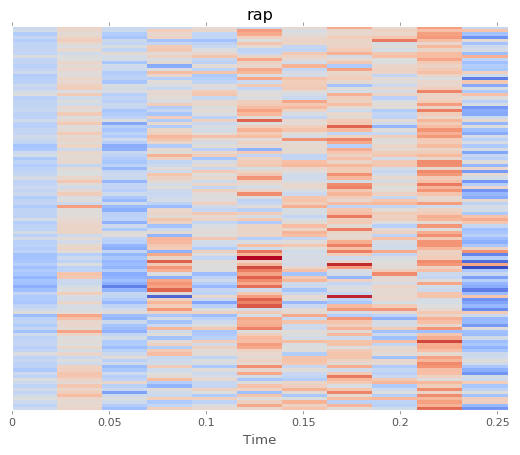

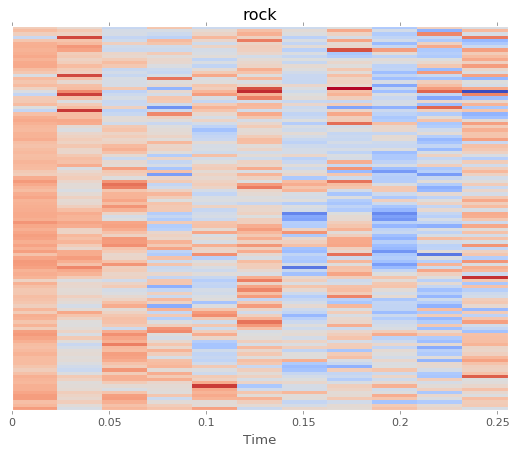

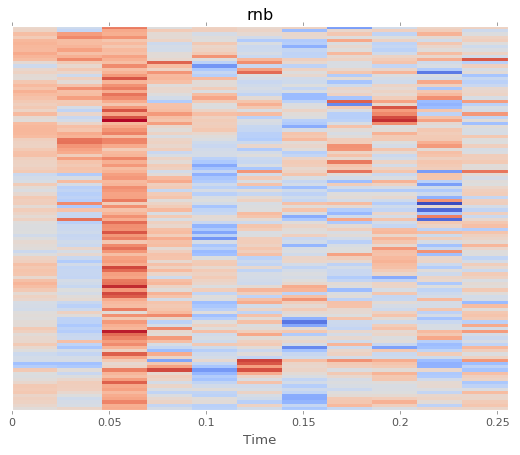

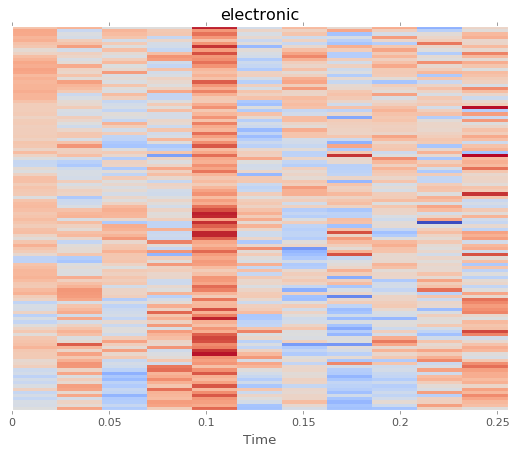

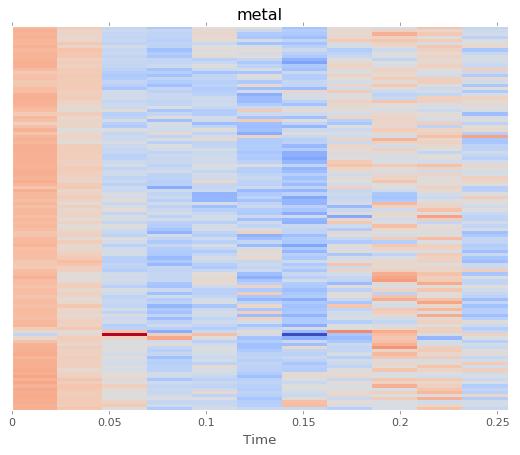

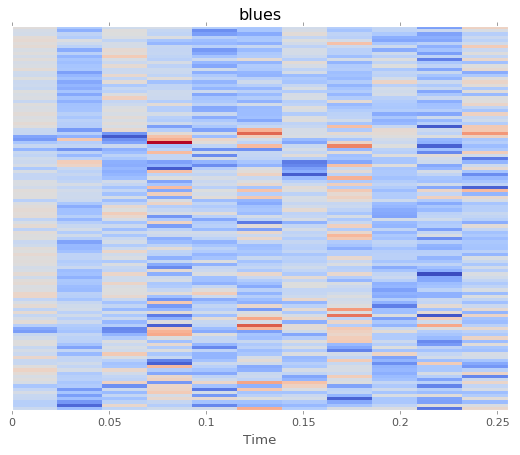

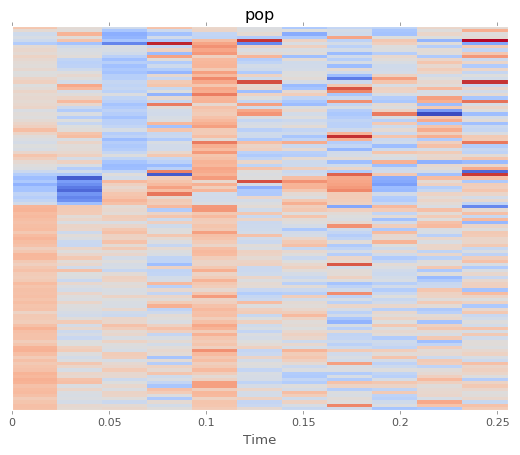

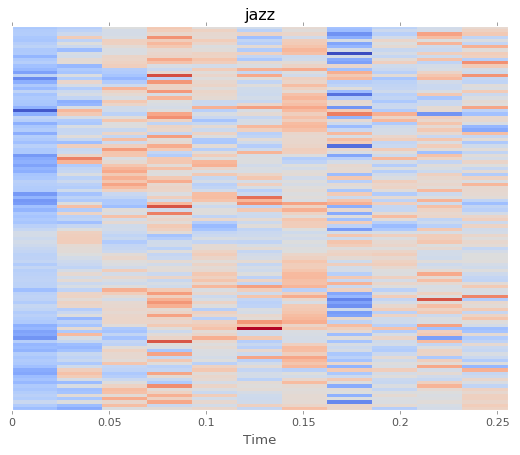

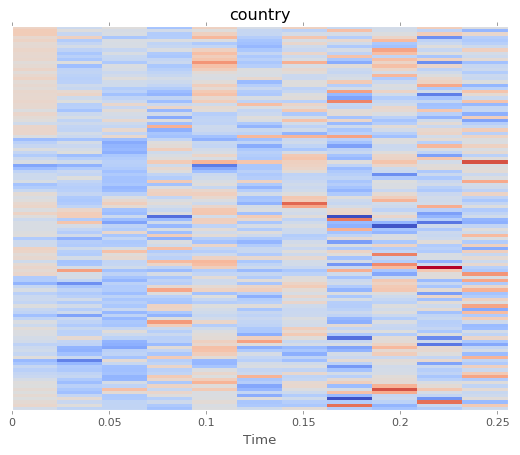

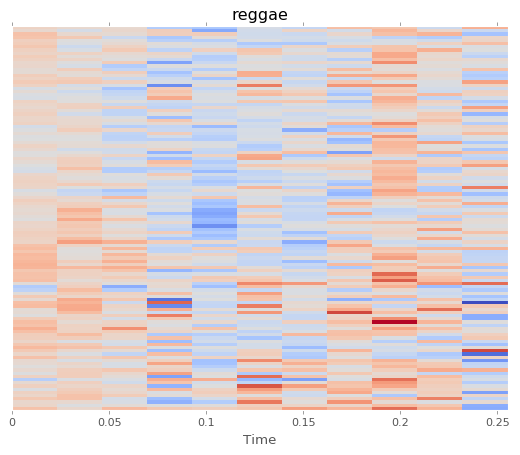

In [88]:

for y in np.unique(y_train):
  idx = np.argmax(y_train==y)
  plt.figure()
  librosa.display.specshow(X_train[idx,:,0:11], x_axis='time')
  z = label_name[y]
  plt.title(z)


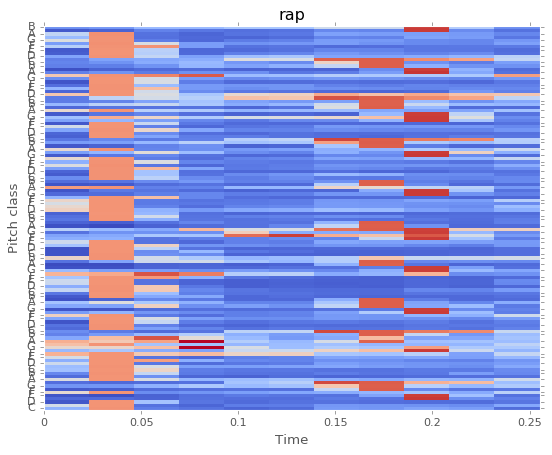

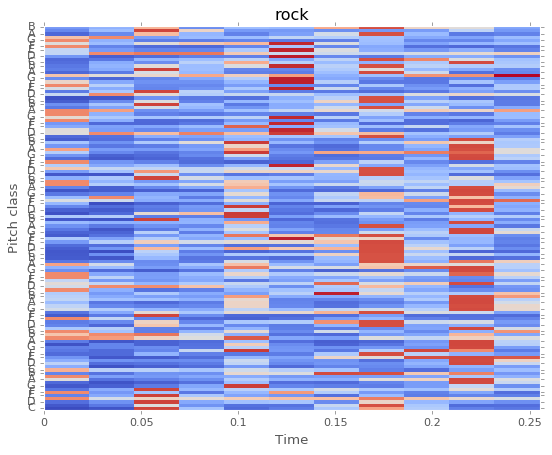

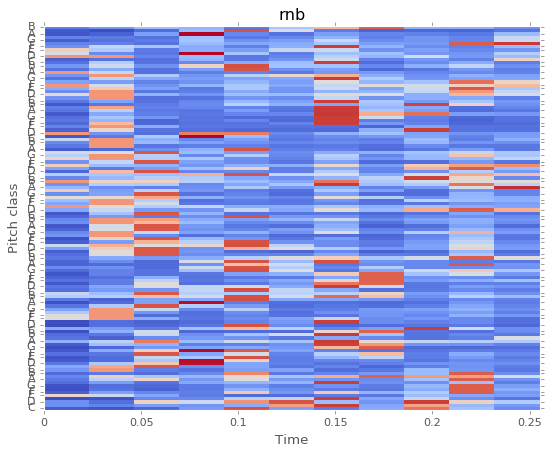

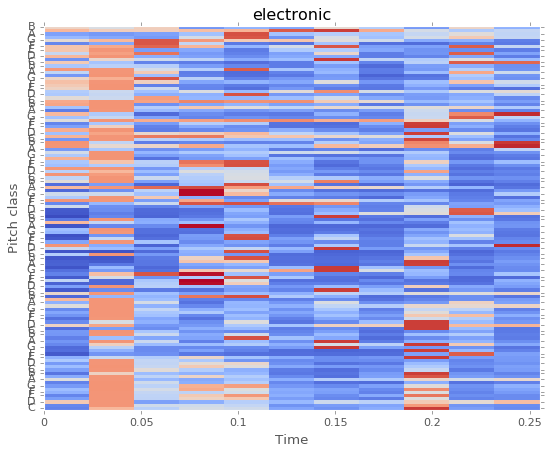

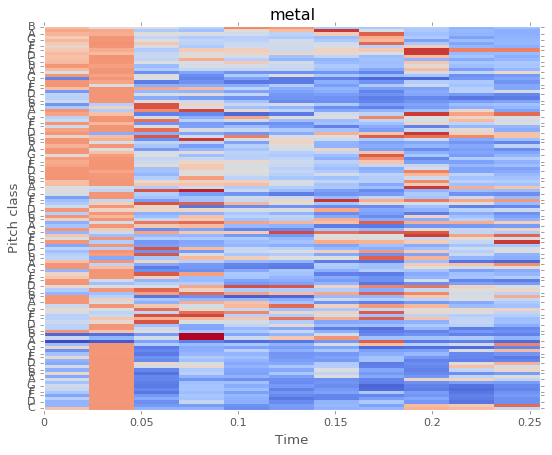

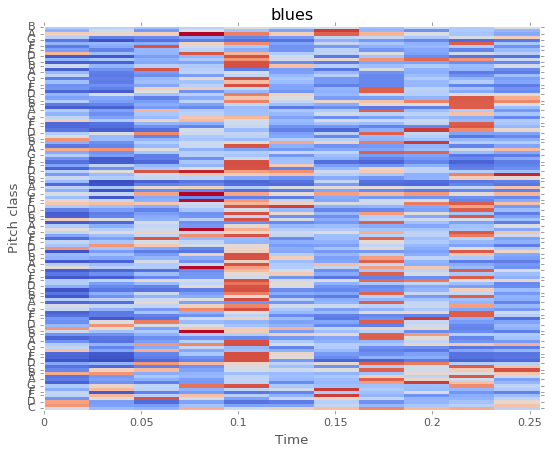

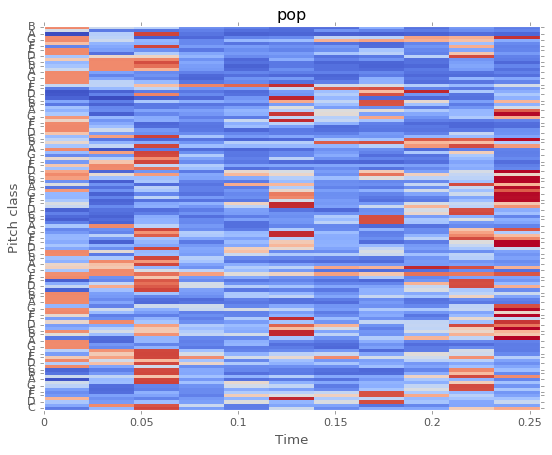

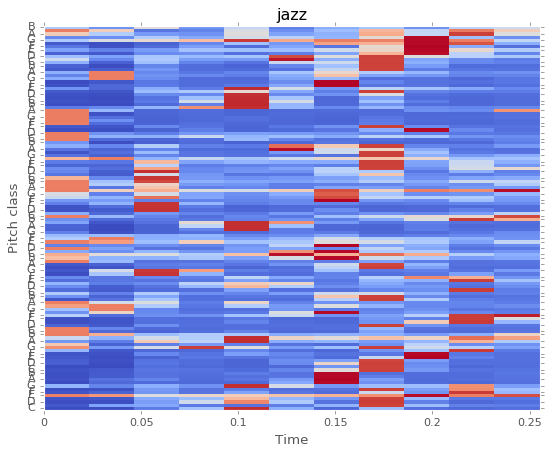

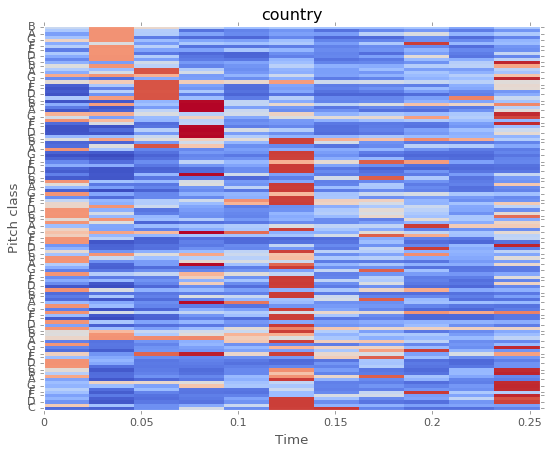

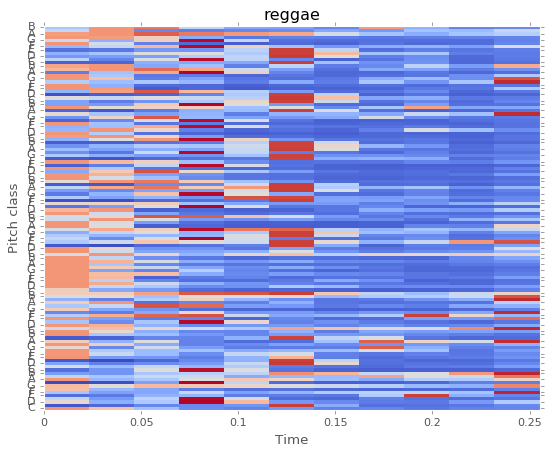

In [87]:
for y in np.unique(y_train):
  idx = np.argmax(y_train==y)
  plt.figure()
  librosa.display.specshow(X_train[idx,:,12:23], y_axis='chroma', x_axis='time')
  plt.title(y)
  z = label_name[y]
  plt.title(z)

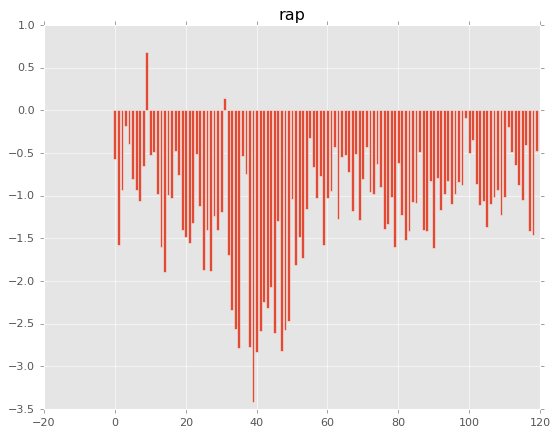

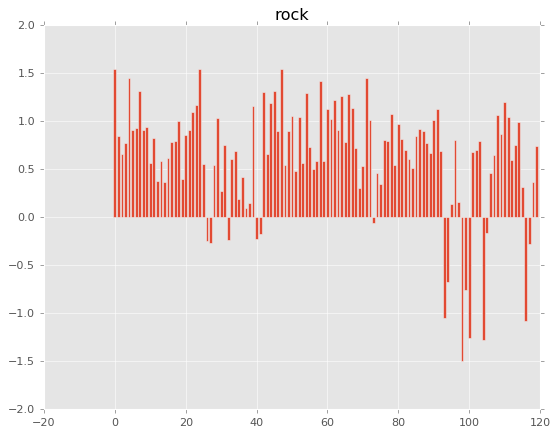

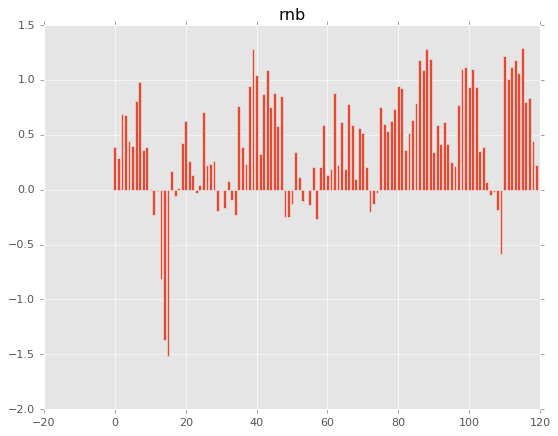

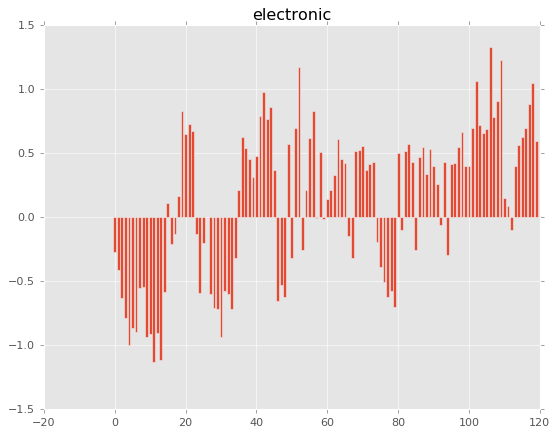

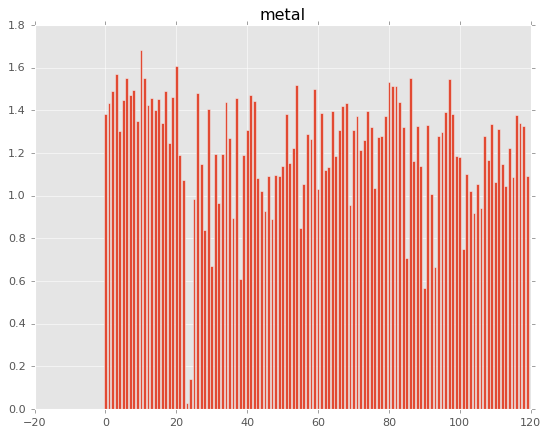

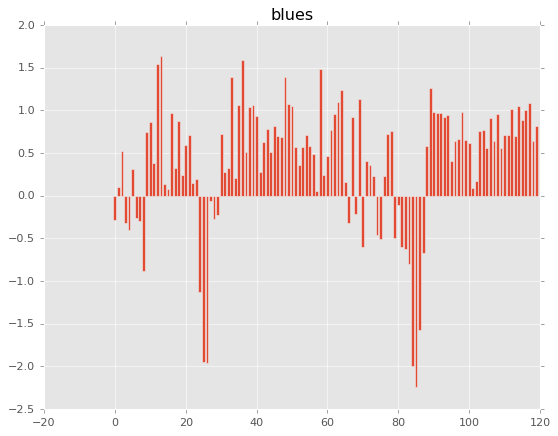

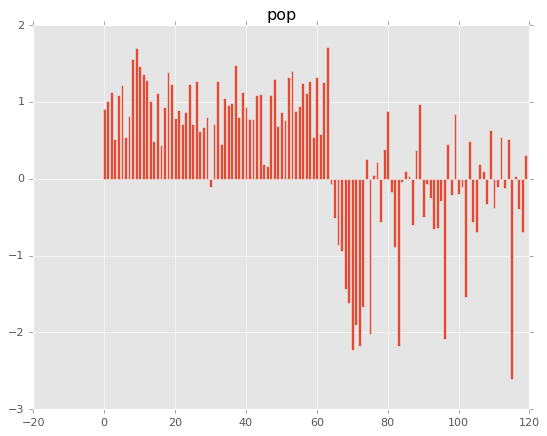

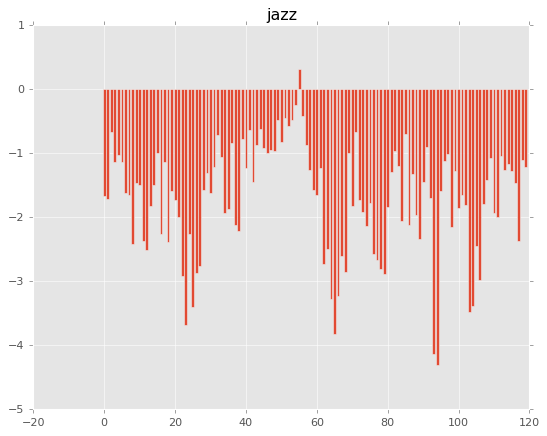

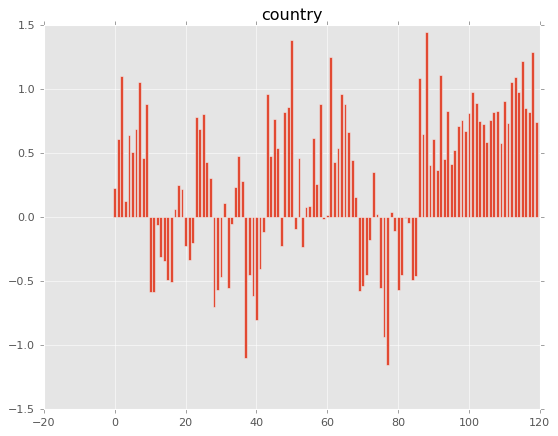

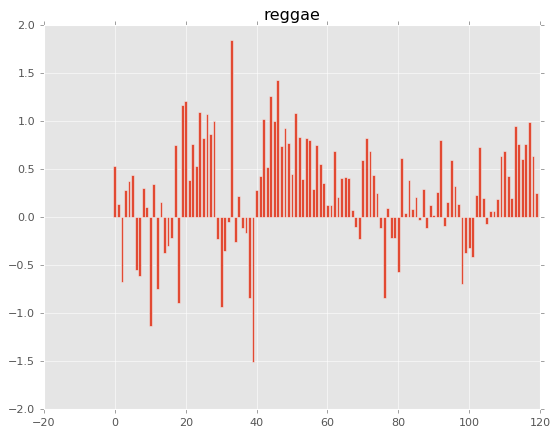

In [86]:
pos = range(120)
for y in np.unique(y_train):
  idx = np.argmax(y_train==y)
  plt.figure()
  plt.bar(pos,X_train[idx,:,24])
  plt.title(y)
  z = label_name[y]
  plt.title(z)
 


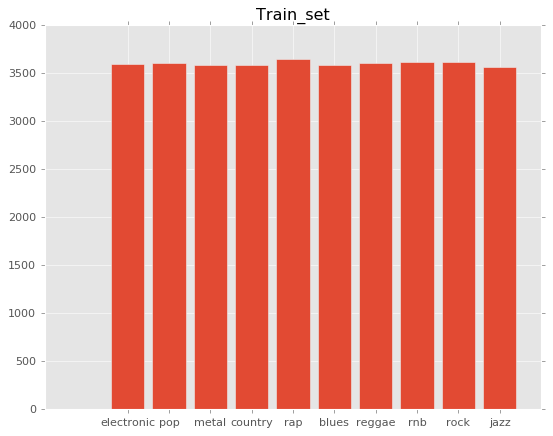

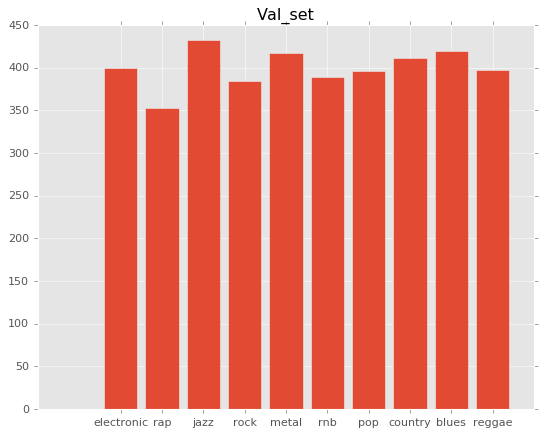

In [85]:

labels, values = zip(*Counter(y_train).items())
indexes = np.arange(len(labels))
plt.bar(indexes, values)
i=0
x=[]
for val in labels:
  x.append(label_name[val])

plt.xticks(np.arange(num_classes), x)
plt.title('Train_set')
plt.show()



labels, values = zip(*Counter(y_val).items())
indexes = np.arange(len(labels))
plt.bar(indexes, values)
i=0
x=[]
for val in labels:
  x.append(label_name[val])

plt.xticks(np.arange(num_classes), x)
plt.title('Val_set')
plt.show()
